## Fixed Effect Model (i really pray it works)

In [2]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

In [61]:
#import data first
training_data=pd.read_csv('../data/final/training_model_data.csv',header=0)
test_data=pd.read_csv('../data/final/incompl_test_model_data.csv',header=0)
test_data=test_data[training_data.columns]
combined=pd.concat([training_data,test_data],axis=0)


In [62]:
un_data=pd.read_csv('../data/final/FBIC_sentiment_comtrade_un.csv',header=0)
un_data=un_data[['iso3a','iso3b','IdealPointDistance','year']]
un_data=un_data.rename(columns={'iso3a':'country_a','iso3b':'country_b','IdealPointDistance':'un_dist'})
combined=combined.merge(un_data,how='left',on=['country_a','country_b','year'])

In [63]:
df = combined.melt(
    id_vars=['year','country_a','country_b','tradeagreementindex','sentiment_index','un_dist'],
    value_vars=['bec_1','bec_2','bec_3','bec_4','bec_5','bec_6','bec_7','bec_8'],
    var_name='sector',
    value_name='value'
)

In [64]:
test_df = pd.merge(
    df, df,
    left_on=['country_a','country_b','year','sector'],
    right_on=['country_b','country_a','year','sector'],
    how='outer',
    suffixes=('_export', '_import')
)

In [19]:
test_df.head()

,year,country_a_export,country_b_export,tradeagreementindex_export,sentiment_index_export,un_dist_export,sector,value_export,country_a_import,country_b_import,tradeagreementindex_import,sentiment_index_import,un_dist_import,value_import
0,2017,ARE,AUS,0,0.385299,1.672998,bec_1,3.882138e+08,AUS,ARE,0,0.396381,1.672998,6.388832e+08
1,2017,ARE,AUS,0,0.385299,1.672998,bec_2,4.860504e+08,AUS,ARE,0,0.396381,1.672998,1.142886e+09
2,2017,ARE,AUS,0,0.385299,1.672998,bec_3,2.264492e+08,AUS,ARE,0,0.396381,1.672998,2.429372e+08
3,2017,ARE,AUS,0,0.385299,1.672998,bec_4,9.393263e+07,AUS,ARE,0,0.396381,1.672998,8.130109e+07
4,2017,ARE,AUS,0,0.385299,1.672998,bec_5,1.668129e+08,AUS,ARE,0,0.396381,1.672998,1.751968e+08


In [65]:
test_df['sentiment_index'] = 0.5 * (test_df['sentiment_index_export'] + test_df['sentiment_index_import'])
test_df=test_df.drop(['country_a_import','country_b_import','sentiment_index_export','sentiment_index_import','tradeagreementindex_import','un_dist_import'],axis=1)

In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
test_df['tradeagreementindex_export']=scaler.fit_transform(test_df['tradeagreementindex_export'].values.reshape(-1,1))
test_df['sentiment_index']=scaler.fit_transform(test_df['sentiment_index'].values.reshape(-1,1))
test_df['D']=1+(-1)*0.5*test_df['tradeagreementindex_export']+(-1)*0.5*test_df['sentiment_index']
test_df=test_df.drop(columns=['sentiment_index','tradeagreementindex_export'],axis=1)

In [67]:
test_df.head()

,year,country_a_export,country_b_export,un_dist_export,sector,value_export,value_import,D
0,2006,ARE,AUS,2.36814,bec_1,0.0,1.905126e+08,0.666298
1,2006,ARE,AUS,2.36814,bec_2,0.0,7.701826e+08,0.666298
2,2006,ARE,AUS,2.36814,bec_3,0.0,1.248102e+08,0.666298
3,2006,ARE,AUS,2.36814,bec_4,0.0,1.492864e+08,0.666298
4,2006,ARE,AUS,2.36814,bec_5,0.0,2.490714e+08,0.666298


In [ ]:
#split up the datasets from here (this is with un records)
original=test_df[['year','country_a_export','country_b_export','un_dist_export','sector','value_export']]
original=original.rename(columns={'un_dist_export':'D','country_a_export':'country_a','country_b_export':'country_b','value_export':'value'})
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
original['D']=scaler.fit_transform(original['D'].values.reshape(-1,1))
df=original


In [54]:
#this is from composite D
new=test_df[['year','country_a_export','country_b_export','D','sector','value_export']]
new=new.rename(columns={'country_a_export':'country_a','country_b_export':'country_b','value_export':'value'})
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
new['D']=scaler.fit_transform(new['D'].values.reshape(-1,1))
df=new

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
combined['tradeagreementindex']=scaler.fit_transform(combined['tradeagreementindex'].values.reshape(-1,1))
combined['sentiment_index']=scaler.fit_transform(combined['sentiment_index'].values.reshape(-1,1))


In [57]:
combined['composite_d']=1+(-1)*0.5*combined['tradeagreementindex']+(-1)*0.5*combined['sentiment_index']
combined=combined.drop(columns=['sentiment_index','tradeagreementindex'],axis=1)

## NOTE

United Arab Empire was removed because most of the trade volumes here are 0..

In [ ]:
df = df[(df['country_a'] != 'ARE') & (df['country_b'] != 'ARE')]

In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Prepare the data
df = df.sort_values(['country_a', 'country_b', 'sector', 'year'])
df['log_export'] = np.log(df['value'])
df['delta_log_export'] = df.groupby(['country_a', 'country_b', 'sector'])['log_export'].diff()

# Create entity ID for panel structure
df['entity_id'] = df['country_a'] + '_' + df['country_b'] + '_' + df['sector']



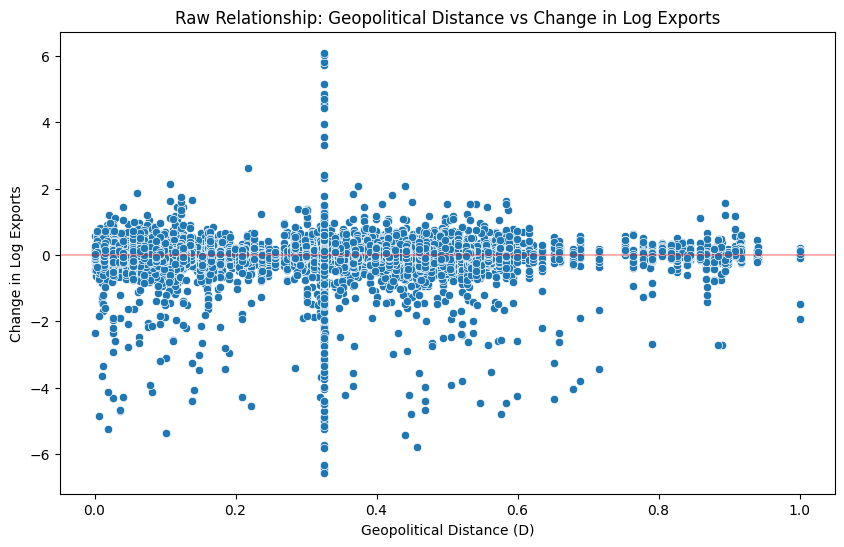

Correlation between D and delta_log_export: 0.0026375420179209587


In [41]:
# Exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Check the raw relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='D', y='delta_log_export', data=df.dropna(subset=['delta_log_export']))
plt.title('Raw Relationship: Geopolitical Distance vs Change in Log Exports')
plt.xlabel('Geopolitical Distance (D)')
plt.ylabel('Change in Log Exports')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show()

# Look at the correlation
correlation = df.dropna(subset=['delta_log_export'])[['D', 'delta_log_export']].corr()
print("Correlation between D and delta_log_export:", correlation.iloc[0, 1])

In [42]:
# Try a simpler model first without fixed effects
panel_data = df.dropna(subset=['delta_log_export']).set_index(['entity_id', 'year'])
panel_data['D'] = panel_data['D'].astype(float)

# Run simple regression without fixed effects
model_simple = PanelOLS.from_formula('delta_log_export ~ D', panel_data)
results_simple = model_simple.fit()
print("Simple model D coefficient:", results_simple.params['D'])

# Now add entity fixed effects only
model_entity = PanelOLS.from_formula('delta_log_export ~ D + EntityEffects', panel_data)
results_entity = model_entity.fit()
print("Entity fixed effects model D coefficient:", results_entity.params['D'])

# Now add time fixed effects only
model_time = PanelOLS.from_formula('delta_log_export ~ D + TimeEffects', panel_data)
results_time = model_time.fit()
print("Time fixed effects model D coefficient:", results_time.params['D'])

# Finally, add both
model_both = PanelOLS.from_formula('delta_log_export ~ D + EntityEffects + TimeEffects', panel_data)
results_both = model_both.fit()
print("Both fixed effects model D coefficient:", results_both.params['D'])

Simple model D coefficient: -0.07943996711564837
Entity fixed effects model D coefficient: -1.0659473100368975
Time fixed effects model D coefficient: 0.024264913156848086
Both fixed effects model D coefficient: -0.38996164661424293


In [45]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Assuming your dataframe is structured with export volumes by country and time period
# And you have a geopolitical distance measure 'D'

# Prepare data
df = df.set_index(['entity_id', 'year'])

# 1. Simple model with no fixed effects
model_simple = PanelOLS.from_formula('delta_log_export ~ D', data=df)
results_simple = model_simple.fit()

# 2. Entity fixed effects model - this gave you the expected negative coefficient
model_entity = PanelOLS.from_formula('delta_log_export ~ D + EntityEffects', data=df)
results_entity = model_entity.fit()

# 3. Time fixed effects model
model_time = PanelOLS.from_formula('delta_log_export ~ D + TimeEffects', data=df)
results_time = model_time.fit()

# 4. Both fixed effects model
model_both = PanelOLS.from_formula('delta_log_export ~ D + EntityEffects + TimeEffects', data=df)
results_both = model_both.fit()

# Print results focusing on the entity fixed effects model
print(f"Entity fixed effects model results (preferred specification):")
print(f"D coefficient: {results_entity.params['D']:.4f}")
print(f"Standard error: {results_entity.std_errors['D']:.4f}")
print(f"t-statistic: {results_entity.tstats['D']:.4f}")
print(f"p-value: {results_entity.pvalues['D']:.4f}")
print("\nModel diagnostics:")
print(f"R-squared: {results_entity.rsquared:.4f}")
print(f"Number of observations: {results_entity.nobs}")

# Additional analysis to understand the differences between models
print("\nComparison of D coefficients across models:")
print(f"Simple model: {results_simple.params['D']:.4f}")
print(f"Entity fixed effects: {results_entity.params['D']:.4f}")
print(f"Time fixed effects: {results_time.params['D']:.4f}")
print(f"Both fixed effects: {results_both.params['D']:.4f}")

c:\Users\rob-l\Documents\NUS\Y3S2\DSE3101\T5G1\venv\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Users\rob-l\Documents\NUS\Y3S2\DSE3101\T5G1\venv\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Users\rob-l\Documents\NUS\Y3S2\DSE3101\T5G1\venv\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Entity fixed effects model results (preferred specification):
D coefficient: 0.2430
Standard error: 0.1038
t-statistic: 2.3415
p-value: 0.0192

Model diagnostics:
R-squared: 0.0004
Number of observations: 15232

Comparison of D coefficients across models:
Simple model: -0.0317
Entity fixed effects: 0.2430
Time fixed effects: -0.1063
Both fixed effects: -0.1848


c:\Users\rob-l\Documents\NUS\Y3S2\DSE3101\T5G1\venv\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## another test of fixed effect

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from patsy import dmatrices

# Prepare data
df_reg = df.dropna(subset=['delta_log_export'])

# Create the sector-time interaction with D
df_reg['sector_year'] = df_reg['sector'] + '_' + df_reg['year'].astype(str)
for sy in df_reg['sector_year'].unique():
    df_reg[f'D_{sy}'] = np.where(df_reg['sector_year'] == sy, df_reg['D'], 0)

# Get all D interaction columns
D_cols = [col for col in df_reg.columns if col.startswith('D_')]
df_reg['importer_fe'] = df_reg['country_b'].astype(str) + '_' + df_reg['sector'].astype(str) + '_' + df_reg['year'].astype(str)
df_reg['exporter_fe'] = df_reg['country_a'].astype(str) + '_' + df_reg['sector'].astype(str) + '_' + df_reg['year'].astype(str)
# Create formula with fixed effects using C() for categorical variables
formula = 'delta_log_export ~ ' + ' + '.join(D_cols) + ' + C(importer_fe) + C(exporter_fe)'

# Use patsy to create design matrices
y, X = dmatrices(formula, df_reg, return_type='dataframe')

# Run OLS regression
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df_reg['country_a'] + '_' + df_reg['country_b']})
print(results.summary())

C:\Users\rob-l\AppData\Local\Temp\ipykernel_19876\1323285350.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['sector_year'] = df_reg['sector'] + '_' + df_reg['year'].astype(str)
C:\Users\rob-l\AppData\Local\Temp\ipykernel_19876\1323285350.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg[f'D_{sy}'] = np.where(df_reg['sector_year'] == sy, df_reg['D'], 0)
C:\Users\rob-l\AppData\Local\Temp\ipykernel_19876\1323285350.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

                            OLS Regression Results                            
Dep. Variable:       delta_log_export   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                -2.360e+10
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               1.00
Time:                        19:59:27   Log-Likelihood:                -2675.1
No. Observations:               14688   AIC:                             8806.
Df Residuals:                   12960   BIC:                         2.193e+04
Df Model:                        1727                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep